# Stock Prediction Model

## Dependencies

### Library Installation (if needed)

In [8]:
#! pip install yfinance pandas numpy matplotlib lightgbm torch tensorflow keras

### Importing Required Libraries

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

### Variables

In [10]:
print_errors = False
build_new_dataset = False
symbol_list = 'advanced' # 'simple' or 'advanced'. simple are the tickers from the screener notebook and advanced are all of the tickers in 'filtered_tickers'

## Data Preparation

In [11]:
if symbol_list == 'simple':
    symbols = pd.read_csv('../data/simple_screener_results.csv')['Ticker'].tolist()
if symbol_list == 'advanced':
    symbols = pd.read_csv('../data/filtered_tickers.csv')['Ticker'].tolist()

symbols = pd.Series(symbols).unique()
symbols

array(['A', 'AA', 'AAT', ..., 'ZEUS', 'ZION', 'ZUMZ'], dtype=object)

#### Download annual financial data

In [12]:
if build_new_dataset:
    df = pd.DataFrame()
    for symbol in tqdm(symbols):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        try:
            # Latest earning data
            latest_earning_date = ticker.quarterly_cash_flow.columns.tolist()[0]
            latest_data = {'Ticker': symbol, 'Date': latest_earning_date}
            latest_data['3M Future Change'] = np.nan
            latest_data['6M Future Change'] = np.nan
            latest_data['1Y Future Change'] = np.nan

            try:
                latest_data['Sector'] = ticker.info['sector']
            except:
                latest_data['Sector'] = 'Unknown'
                
            try:
                latest_data['Industry'] = ticker.info['industry']
            except:
                latest_data['Industry'] = 'Unknown'

            for column in ticker.quarterly_cash_flow[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_cash_flow[latest_earning_date][column]

            for column in ticker.quarterly_balance_sheet[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_balance_sheet[latest_earning_date][column]

            for column in ticker.quarterly_income_stmt[latest_earning_date].keys().tolist():
                latest_data[column] = ticker.quarterly_income_stmt[latest_earning_date][column]

            ticker_df = pd.concat([ticker_df, pd.DataFrame([latest_data])], ignore_index=True)

            # Annual data
            earning_dates = ticker.cash_flow.columns.tolist()
            price_data = yf.download(symbol, period='10y', rounding=False, progress=False)
            cash_flow = ticker.cash_flow
            cash_flow_columns = cash_flow[earning_dates[0]].keys().tolist()
            balance_sheet = ticker.balance_sheet
            balance_sheet_columns = balance_sheet[earning_dates[0]].keys().tolist()
            income_statement = ticker.income_stmt
            income_statement_columns = income_statement[earning_dates[0]].keys().tolist()
            for earning_date in earning_dates:
                earning_date_data = {'Ticker': symbol, 'Date': earning_date}
                got_price = False
                day_offset = 0
                while(got_price==False and day_offset > -6):
                    try:           
                        earning_date_data['3M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=13) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['6M Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=26) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        earning_date_data['1Y Future Change'] = (
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset, weeks=52) , ('Close', symbol)]) / 
                            float(price_data.loc[earning_date + pd.Timedelta(days=day_offset), ('Close', symbol)]) - 1
                        )
                        got_price = True
                    except:
                        day_offset += -1

                try:
                    earning_date_data['Sector'] = ticker.info['sector']
                except:
                    earning_date_data['Sector'] = 'Unknown'
                
                try:
                    earning_date_data['Industry'] = ticker.info['industry']
                except:
                    earning_date_data['Industry'] = 'Unknown'

                for column in cash_flow_columns:
                    earning_date_data[column] = cash_flow[earning_date][column]

                for column in balance_sheet_columns:
                    earning_date_data[column] = balance_sheet[earning_date][column]

                for column in income_statement_columns:
                    earning_date_data[column] = income_statement[earning_date][column]
                
                if got_price:
                    ticker_df = pd.concat([ticker_df, pd.DataFrame([earning_date_data])], ignore_index=True)

            if len(ticker_df) != 5:
                continue

            imputer = SimpleImputer()
            for column in ticker_df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
                if not ticker_df[column].isna().all():
                    ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if print_errors:
                print(f'Error for {symbol}: {error}')
            continue

    df.to_csv('../data/earnings_data.csv', index=False)
else:
    df = pd.read_csv('../data/earnings_data.csv')

### Short visualisation

In [13]:
df

,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,AA,2024-12-31,NaN,NaN,NaN,Basic Materials,Aluminum,246000000.0,-2.166667e+08,-3.940000e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AA,2023-12-31,-0.018451,0.130405,0.123098,Basic Materials,Aluminum,-440000000.0,0.000000e+00,-7.200000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AA,2022-12-31,-0.062309,-0.250328,-0.243344,Basic Materials,Aluminum,342000000.0,-5.000000e+08,-1.000000e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AA,2021-12-31,0.522660,-0.246283,-0.231174,Basic Materials,Aluminum,530000000.0,-1.500000e+08,-1.294000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AA,2020-12-31,0.398265,0.603471,1.574374,Basic Materials,Aluminum,169500000.0,-2.166667e+08,-4.402500e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5190,ZUMZ,2025-01-31,NaN,NaN,NaN,Consumer Cyclical,Apparel Retail,49699000.0,0.000000e+00,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5191,ZUMZ,2024-01-31,-0.002912,0.480489,-0.089691,Consumer Cyclical,Apparel Retail,-5595000.0,0.000000e+00,-4.944000e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5192,ZUMZ,2023-01-31,-0.363531,-0.272938,-0.313202,Consumer Cyclical,Apparel Retail,-26006000.0,-8.786000e+07,-2.268800e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5193,ZUMZ,2022-01-31,-0.155506,-0.400445,-0.428254,Consumer Cyclical,Apparel Retail,119201000.0,-1.937890e+08,-2.480000e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [14]:
imputer = SimpleImputer()
scaler = StandardScaler()
for column in df.columns.drop(['Ticker', 'Date', '3M Future Change', '6M Future Change', '1Y Future Change', 'Sector', 'Industry']):
    df[column] = imputer.fit_transform(df[[column]])
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

le = LabelEncoder()
for column in ['Ticker', 'Sector', 'Industry']:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Splitting

In [15]:
pred_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    pred_data = pd.concat([pred_data, df.iloc[[i*5]]]) 
print('Prediction Data:')
display(pred_data)

train_data = pd.DataFrame()
for i in range(int(len(df) / 5)):
    train_data = pd.concat([train_data, df.iloc[[1+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[2+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[3+i*5]]])
    train_data = pd.concat([train_data, df.iloc[[4+i*5]]])
print('Train and Test Data:')
display(train_data)

Prediction Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
0,0,2024-12-31,NaN,NaN,NaN,0,5,-0.018462,0.062248,0.060830,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5,1,2024-12-31,NaN,NaN,NaN,8,94,-0.018670,0.000000,0.060917,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
10,2,2025-01-31,NaN,NaN,NaN,7,120,-0.018803,0.070910,0.060836,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
15,3,2024-12-31,NaN,NaN,NaN,8,98,-0.018646,0.071855,0.060022,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
20,4,2024-12-31,NaN,NaN,NaN,6,74,-0.016703,0.057888,0.060758,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5170,1034,2024-12-31,NaN,NaN,NaN,6,76,-0.018656,0.071855,0.060923,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5175,1035,2024-12-31,NaN,NaN,NaN,11,139,-0.018695,0.000000,0.060944,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5180,1036,2024-12-31,NaN,NaN,NaN,1,66,-0.018615,0.071855,0.060800,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5185,1037,2024-12-31,NaN,NaN,NaN,9,24,-0.018423,0.070480,0.060946,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0


Train and Test Data:


,Ticker,Date,3M Future Change,6M Future Change,1Y Future Change,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
1,0,2023-12-31,-0.018451,0.130405,0.123098,0,5,-0.019096,0.071855,0.060925,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
2,0,2022-12-31,-0.062309,-0.250328,-0.243344,0,5,-0.018373,0.049685,0.060946,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
3,0,2021-12-31,0.522660,-0.246283,-0.231174,0,5,-0.018199,0.065204,0.060566,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
4,0,2020-12-31,0.398265,0.603471,1.574374,0,5,-0.018533,0.062248,0.060817,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
6,1,2023-12-31,-0.031142,-0.031311,0.220023,8,94,-0.018592,0.000000,0.060891,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5189,1037,2020-12-31,0.279577,0.384279,0.554758,9,24,-0.018315,0.061978,0.060888,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5191,1038,2024-01-31,-0.002912,0.480489,-0.089691,2,7,-0.018695,0.071855,0.060932,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5192,1038,2023-01-31,-0.363531,-0.272938,-0.313202,2,7,-0.018714,0.067959,0.060939,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5193,1038,2022-01-31,-0.155506,-0.400445,-0.428254,2,7,-0.018579,0.063262,0.060946,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0


### Labeling

In [16]:
X_pred = pred_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
X_train = train_data.drop(['Date', '3M Future Change', '6M Future Change', '1Y Future Change'], axis=1)
y_train = train_data[['3M Future Change', '6M Future Change', '1Y Future Change']]

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    shuffle=True,
)

display(X_train)
display(y_train)
display(X_test)
display(y_test)

,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
5171,1034,6,76,-0.018479,0.058553,6.094402e-02,-6.228707e-02,0.059308,-0.079140,-0.078460,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
901,259,3,56,-0.018317,0.071755,6.041014e-02,-6.187660e-02,0.059239,-0.079173,-0.078531,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
4229,581,6,36,-0.018685,0.000000,6.094433e-02,-6.228531e-02,0.059443,-0.079328,-0.078680,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
3031,977,2,7,-0.014680,-0.038284,6.079934e-02,-6.176129e-02,0.057845,-0.075681,-0.074908,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
4233,585,2,11,-0.018707,0.071748,6.094607e-02,-6.228624e-02,0.059429,-0.079248,-0.078615,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,468,0,22,-0.018859,0.071855,5.987952e-02,-6.127505e-02,0.059272,-0.078991,-0.078523,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
4647,783,6,91,-0.018669,0.071855,8.955902e-18,-1.608036e-17,0.059442,-0.079291,-0.078637,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
1177,355,0,22,-0.013680,-0.031234,6.064674e-02,-6.178122e-02,0.057533,-0.076807,-0.076607,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
3533,235,1,126,-0.002885,-0.135299,5.757179e-02,-6.159469e-02,0.048235,-0.073594,-0.070537,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
5171,-0.062821,-0.285891,-0.452232
901,-0.107404,0.010578,-0.184703
4229,-0.044753,-0.094136,0.009259
3031,-0.008113,0.199415,0.326823
4233,-0.031153,-0.258567,-0.283489
...,...,...,...
4043,-0.094074,-0.169448,-0.122555
4647,-0.098131,-0.329958,-0.685651
1177,0.101254,0.085003,0.147063
3533,-0.047562,-0.190979,-0.286780


,Ticker,Sector,Industry,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Capital Expenditure,End Cash Position,Beginning Cash Position,...,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Customers,Excise Taxes,Current Deferred Taxes Assets,Change In Dividend Payable,Depletion,Restricted Common Stock,Net Income Extraordinary,Net Income From Tax Loss Carryforward
641,190,2,109,-0.018544,0.071855,0.060943,-0.062287,5.942764e-02,-0.079105,-0.078539,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
169,46,8,101,-0.018590,0.070862,0.060806,-0.062156,7.094583e-18,-0.079339,-0.078686,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
2974,960,7,43,-0.018494,0.069837,0.060813,-0.062073,5.936618e-02,-0.079141,-0.078437,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
1749,556,7,122,-0.016776,0.020587,0.060743,-0.062148,5.914875e-02,-0.078662,-0.077716,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
1657,538,7,43,-0.018679,0.071855,0.060917,-0.062252,5.941977e-02,-0.079320,-0.078669,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,250,7,27,-0.018669,0.071441,0.060792,-0.062192,5.939469e-02,-0.079063,-0.078671,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
3248,48,3,44,-0.018695,0.071855,0.060925,-0.062274,5.942585e-02,-0.079358,-0.078700,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
5158,1031,7,1,-0.018295,0.070376,0.060894,-0.062267,5.941150e-02,-0.079065,-0.078608,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0
1368,430,1,93,-0.018608,0.071711,0.060309,-0.061777,5.940976e-02,-0.079265,-0.078570,...,0.0,-6.899835e-16,0.0,0.0,-1.352204e-15,0.0,0.0,0.0,0.0,0.0


,3M Future Change,6M Future Change,1Y Future Change
641,0.332683,0.280750,0.273721
169,0.397236,0.599966,0.580782
2974,0.329861,0.364037,0.271630
1749,0.091321,0.112891,0.228995
1657,0.990902,1.243586,1.533787
...,...,...,...
876,0.075125,-0.019338,0.080108
3248,0.082640,0.127465,-0.127192
5158,-0.028253,0.106708,-0.281480
1368,-0.144465,-0.454034,-0.619137


## Model Training

In [ ]:
base_model = MLPRegressor()

param_grid = {
    'shuffle': [True], 
    'solver': ['adam'], 
    'learning_rate': ['adaptive'],
    'tol': [0.0001],
    'max_iter': [200],
    'alpha': [0.0001],
    'hidden_layer_sizes': [(500, 500), (1000, 1000), (2000, 2000)],
    'learning_rate_init': [0.001],
    'n_iter_no_change': [3, 6, 9]
}

grid_search = GridSearchCV(
    estimator=base_model, 
    param_grid=param_grid, 
    scoring='r2', 
    cv=3, 
    n_jobs=3,
    verbose=1,
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model = grid_search.best_estimator_
print('Best Parameters:')
print(best_params)

model.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


## Testing and benchmarking

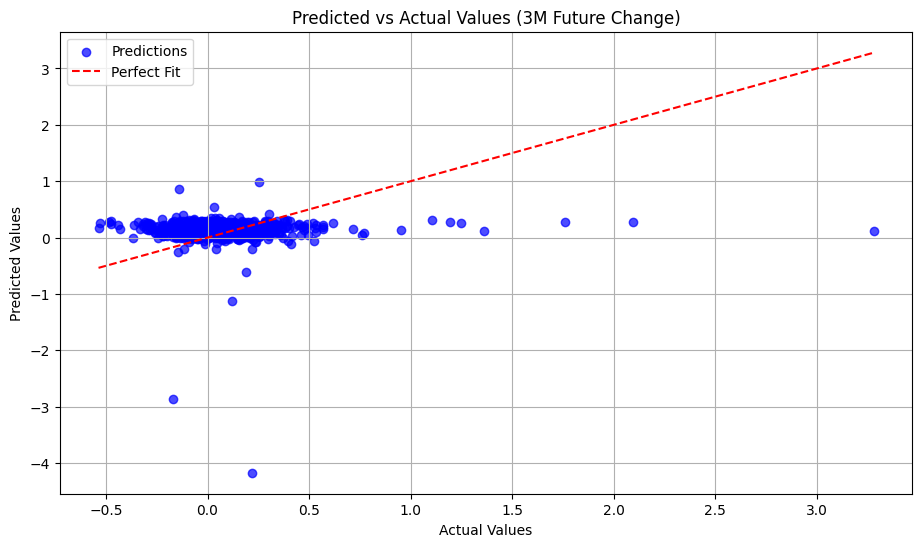

3M Future Change - R²: -0.8342
3M Future Change - MSE: 0.1342
3M Future Change - MAE: 0.2149


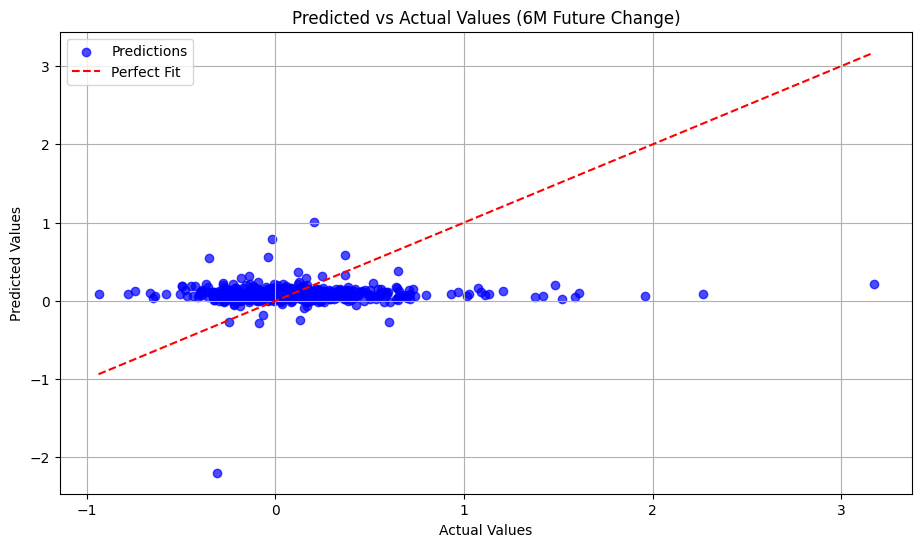

6M Future Change - R²: -0.0885
6M Future Change - MSE: 0.1403
6M Future Change - MAE: 0.2503


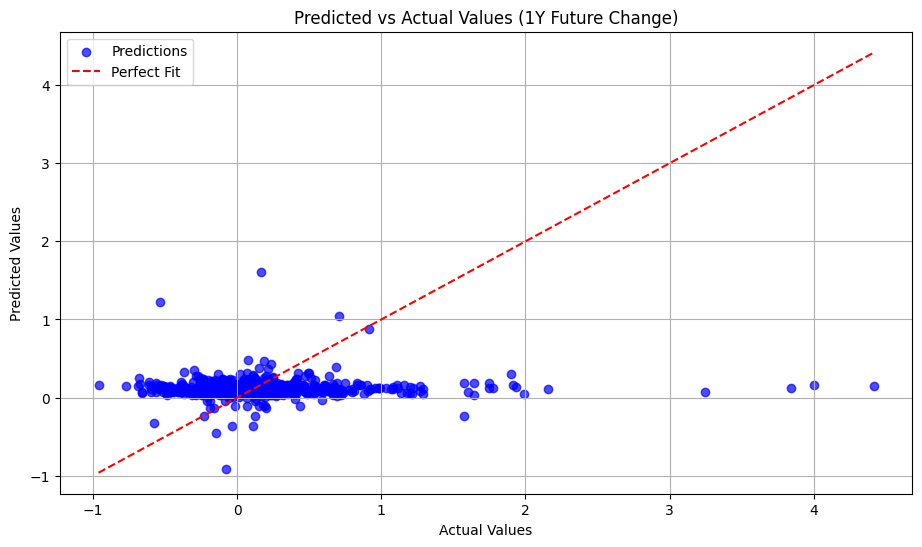

1Y Future Change - R²: -0.0532
1Y Future Change - MSE: 0.3037
1Y Future Change - MAE: 0.3530

Overall Scores:
Mean - R²: -0.3253
Mean - MSE: 0.1928
Mean - MAE: 0.2727


In [ ]:
y_test_pred = model.predict(X_test)

for i, target in enumerate(['3M Future Change', '6M Future Change', '1Y Future Change']):
    y_test_actual = y_test[target]
    y_test_pred_target = y_test_pred[:, i]

    plt.figure(figsize=(11, 6))
    plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
    plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
        color='red', linestyle='--', label='Perfect Fit')
    plt.title(f'Predicted vs Actual Values ({target})')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

    mae = mean_absolute_error(y_test_actual, y_test_pred_target)
    mse = mean_squared_error(y_test_actual, y_test_pred_target)
    r2 = r2_score(y_test_actual, y_test_pred_target)

    print(f'{target} - R²: {r2:.4f}')
    print(f'{target} - MSE: {mse:.4f}')
    print(f'{target} - MAE: {mae:.4f}')

mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print('\nOverall Scores:')
print(f'Mean - R²: {r2:.4f}')
print(f'Mean - MSE: {mse:.4f}')
print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [ ]:
test_results = pd.DataFrame({
    'R²': r2,
    'MSE': mse,
    'MAE': mae,
    'symbol_list': symbol_list,
    'hidden_layer_sizes': [model.hidden_layer_sizes],
    'max_iter': model.max_iter,
    'n_iter_no_change': model.n_iter_no_change,
    'learning_rate': model.learning_rate,
    'learning_rate_init': model.learning_rate_init,
    'batch_size': model.batch_size,
    'tol': model.tol,
    'alpha': model.alpha,
    'shuffle': model.shuffle,
})
test_results.to_csv('../data/test_results.csv', mode='a', index=False)

## Predictions on latest data